In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

import tensorly as tl
from tensorly.decomposition import parafac

import CP_ALS3 as cp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor

In [2]:
@jit(nopython=True)
def generate_system(coo_tensor, vals, shape, mode, a, b, l2, step):
    mtx = np.zeros((a.shape[1], a.shape[1]))
    right = np.zeros((a.shape[1]))
    mask = coo_tensor[:, mode] == step
    coo_step = coo_tensor[mask]
    vals_step = vals[mask]
    
    if mode == 0:
        mode_a = 1 
        mode_b = 2
        
    elif mode == 1:
        mode_a = 0
        mode_b = 2
        
    else:
        mode_a = 0
        mode_b = 1
        
    for i in range(a.shape[1]):
        for j in range(a.shape[1]):
            for item in range(coo_step.shape[0]):
                coord = coo_step[item]
                mtx[i, j] += (a[coord[mode_a], i] 
                              * b[coord[mode_b], i] 
                              * a[coord[mode_a], j] 
                              * b[coord[mode_b], j])
                if i == 0:
                    right[j] += a[coord[mode_a], j] * b[coord[mode_b], j] * vals_step[item]
            
            if i == j:
                mtx[i, j] += l2
    
    return mtx, right

In [3]:
@jit(nopython=True) 
def wrcp_als3(coo_tensor,
              vals,
              shape,
              rank=5,
              l2=0.5,
              max_iter=50,
              tol=1e-8):
    
    a = np.random.normal(0.0, 0.1, size=(shape[0], rank))
    b = np.random.normal(0.0, 0.1, size=(shape[1], rank))
    c = np.random.normal(0.0, 0.1, size=(shape[2], rank))
    err_arr = np.empty((max_iter, 1))  
    
    it = 0
    err1 = 1.0
    err2 = 0.0
    while np.abs(err1 - err2) > tol:
        it += 1
        
        for i in range(shape[0]):
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       0,
                                       b,
                                       c, 
                                       l2,
                                       i)
            
            #a[i, :] = np.linalg.pinv(A) @ right
            a[i, :] = np.linalg.solve(A, right)
            
        for j in range(shape[1]):
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       1,
                                       a,
                                       c, 
                                       l2,
                                       j)
            
            #b[j :] = np.linalg.pinv(A) @ right
            b[j :] = np.linalg.solve(A, right)
            
        for k in range(shape[2]):   
            A, right = generate_system(coo_tensor,
                                       vals,
                                       shape,
                                       2,
                                       a,
                                       b, 
                                       l2,
                                       k)
            
            #c[k, :] = np.linalg.pinv(A) @ right
            c[k, :] = np.linalg.solve(A, right)
    
        error = sqrt_err_relative(coo_tensor, vals, shape, a, b, c)
        err_arr[it - 1] = error
        err2 = err1
        err1 = error
        if it == max_iter:
            print("iterations over")
            break
    
    return a, b, c, err_arr, it

# Random Matrix:

In [4]:
%%time
init_shape = (7, 9, 11)
coo, vals = gen_coo_tensor(init_shape, density=0.02)
assert check_coo_tensor(coo)!= "Bad"
coo.shape[0]

CPU times: user 1.43 s, sys: 15.2 ms, total: 1.45 s
Wall time: 1.45 s


13

## WRCP-ALS3:

In [9]:
%%time
max_iter = 25
rank = 2
l2 = 1e-5
a, b, c, err, it = wrcp_als3(coo, vals, init_shape, rank=rank, l2=l2, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, init_shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 9.542946931537581e-06;
CPU times: user 2.36 ms, sys: 0 ns, total: 2.36 ms
Wall time: 2.29 ms


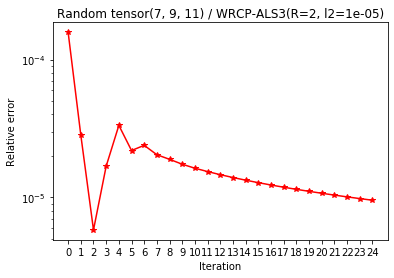

In [10]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Random tensor{init_shape} / WRCP-ALS3(R={rank}, l2={l2})")
plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

# Small Rank Matrix:

In [11]:
shape = (5, 7, 9)
rank = 3
ten = np.zeros(shape=shape)
p = np.zeros(shape=(shape[0], rank))
q = np.zeros(shape=(shape[1], rank))
r = np.zeros(shape=(shape[2], rank))
all_elem = np.prod(shape)
all_elem

315

In [12]:
p[0] = [1, 0, 0]
p[1] = [0, 1, 0]
p[2] = [0, 0, 1]

q[0] = [1, 0, 0]
q[1] = [0, 1, 0]
q[2] = [0, 0, 1]

r[0] = [1, 0, 0]
r[1] = [0, 1, 0]
r[2] = [0, 0, 1]

p[3] = [1, 1, 1]
q[3] = [1, 0, 1]
r[3] = [1, 0, 1]

p[4] = [1, 1, 1]
q[5] = [1, 0, 1]
r[6] = [1, 0, 1]
r[8] = [1, 1, 1]

In [13]:
coo = list()
vals = list()
nnz = 0
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            temp = np.sum(p[i, :] * q[j, :] * r[k, :])
            ten[i, j, k] = temp
            if temp != 0:
                vals.append(temp)
                coo.append((i, j, k))
                nnz += 1
coo = np.array(coo)
vals = np.array(vals)
nnz

66

## Let Max_Iter = 25:

In [14]:
max_iter = 25
rank = 3

## WRCP-ALS3:

In [15]:
%%time
l2 = 1e-4
a, b, c, err, it = wrcp_als3(coo, vals, shape, rank=rank, l2=l2, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.0020520415524844593;
CPU times: user 5.23 s, sys: 7.68 ms, total: 5.24 s
Wall time: 5.24 s


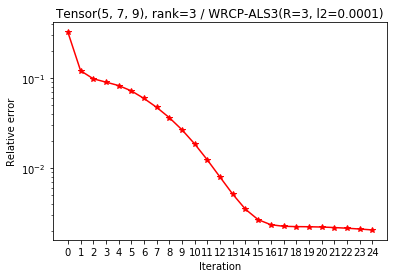

In [16]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank}, l2={l2})")
plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

## TensorLy:

In [17]:
(w, f), err = parafac(
    tensor=ten,
    rank=rank,
    n_iter_max=max_iter,
    init="random",
    random_state=1,
    return_errors=True,
)
rerror = sqrt_err_relative(coo, vals, shape, f[0], f[1], f[2])
print(f"Rel err = {rerror};")

Rel err = 0.0012857429426993312;


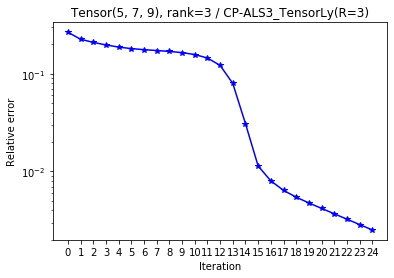

In [18]:
name = "CP-ALS3_TensorLy"
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / {name}(R={rank})")
plt.xticks(np.arange(len(err)))
plt.yscale("log")
plt.plot(np.arange(len(err)), err, 'b-*')

## CP-ALS3:

In [21]:
%%time
a, b, c, err, it = cp.cp_als3(coo, vals, shape, rank=rank, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.0007433936814097446;
CPU times: user 6.06 ms, sys: 34 µs, total: 6.1 ms
Wall time: 5.66 ms


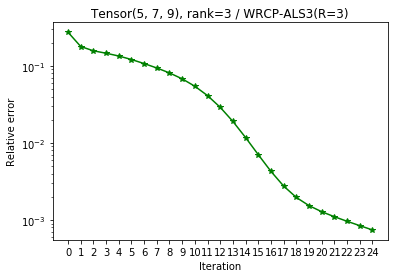

In [22]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank})")
plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'g-*')

## Let Max_Iter = 100:

In [23]:
max_iter = 100
rank = 3

## WRCP-ALS3:

In [43]:
%%time
l2 = 1e-4
a, b, c, err, it = wrcp_als3(coo, vals, shape, rank=rank, l2=l2, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 0.0007015725768910664;
CPU times: user 9.42 ms, sys: 23 µs, total: 9.44 ms
Wall time: 9.88 ms


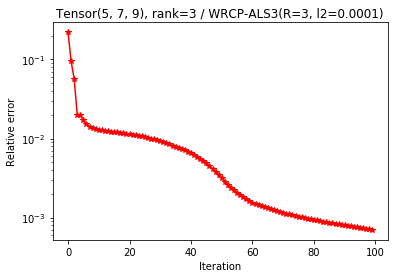

In [44]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank}, l2={l2})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(it), err[:it], 'r-*')

## TensorLy:

In [45]:
(w, f), err = parafac(
    tensor=ten,
    rank=rank,
    n_iter_max=max_iter,
    init="random",
    random_state=1,
    return_errors=True,
)
rerror = sqrt_err_relative(coo, vals, shape, f[0], f[1], f[2])
print(f"Rel err = {rerror};")

Rel err = 2.3803386025349737e-07;


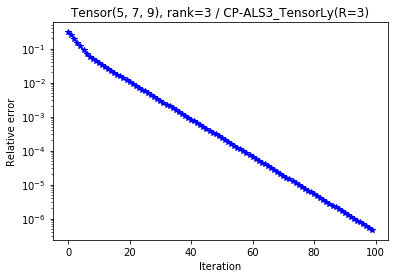

In [46]:
name = "CP-ALS3_TensorLy"
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / {name}(R={rank})")
#plt.xticks(np.arange(len(err)))
plt.yscale("log")
plt.plot(np.arange(len(err)), err, 'b-*')

## CP-ALS3:

In [48]:
%%time
a, b, c, err, it = cp.cp_als3(coo, vals, shape, rank=rank, max_iter=max_iter)
rerror = sqrt_err_relative(coo, vals, shape, a, b, c)
print(f"Rel err = {rerror};")

iterations over
Rel err = 1.546963673034994e-07;
CPU times: user 12.8 ms, sys: 11 µs, total: 12.8 ms
Wall time: 12.4 ms


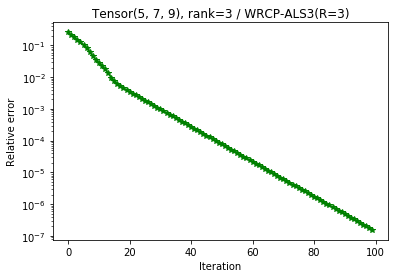

In [49]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"Tensor{shape}, rank={rank} / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(max_iter))
plt.yscale("log")
plt.plot(np.arange(max_iter), err[:max_iter], 'g-*')